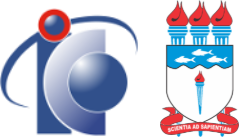

> ## **UNIVERSIDADE FEDERAL DE ALAGOAS - UFAL**
> ### **INSTITUTO DE COMPUTAÇÃO - IC**
> #### Nome: **José Arthur Lopes Sabino**&emsp;&emsp;&emsp; **|**&emsp;&emsp; Matrícula: **20211839**&emsp;&emsp;**|**&emsp;&emsp;Curso: **Ciência da Computação**
> #### Nome: **Karla Sophia Santana da Cruz**&emsp;&nbsp; **|**&emsp;&emsp; Matrícula: **19111113**&emsp;&emsp;**|**&emsp;&emsp;Curso: **Engenharia de Computação**
> #### Período: **2023.1**

> # **Otimização Bioinspirada - Erick Barbosa**
> ## **PROJETO 2**

## **Implementação**

### Imports

In [ ]:
import importlib
import subprocess

libraries_to_check = ['deap', 'ruamel.yaml', 'scipy']

for library in libraries_to_check:
    try:
        importlib.import_module(library)
        print(f"{library} is already installed.")
    except ImportError:
        print(f"{library} is not installed. Installing {library}...")
        subprocess.check_call(['pip', 'install', library])
        print(f"{library} has been successfully installed.")


deap is already installed.
ruamel.yaml is already installed.
scipy is already installed.


In [ ]:
from ruamel.yaml import YAML
import random
import numpy as np
from deap import base, creator, tools, algorithms
import pandas as pd
from scipy.stats import entropy as scipy_entropy
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.font_manager import FontProperties
import time

In [ ]:
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in divide")

In [ ]:
plt.style.use('ggplot')

### Dados

In [ ]:
# Constants and Parameters
MAX_GENERATION_NUMBER = 100
POPULATION_SIZE = 500
TOURNAMENT_SELECTION_SIZE = 3
CROSSING_RATE = 0.9
MUTATION_RATE = 0.3
NUMBER_OF_ELITE_CHROMOSOMES = 1
MAX_FITNESS = 1.0

RAW_DATA_FILE = "raw_data.yml"

# Load raw data from YAML file
yaml = YAML(typ='safe')
with open(RAW_DATA_FILE, 'r') as raw_data_file:
    RAW_DATA = yaml.load(raw_data_file)

In [ ]:
classes = RAW_DATA["classes"]
cols = RAW_DATA["course_mapping"]
rooms = RAW_DATA["rooms"]
days = RAW_DATA["days"]
hours = RAW_DATA["hours"]

LEN_ROOMS = sum(rooms["number"])
LEN_CLASSES = len(classes)
LEN_DAYS = len(days)
LEN_HOURS = len(hours)
LEN_COLS = len(cols)
LEN_ROWS = LEN_CLASSES * LEN_DAYS * LEN_HOURS

shape = (LEN_CLASSES * LEN_DAYS * LEN_HOURS, LEN_COLS)

### Funções Auxiliares

In [ ]:
tab20 = ListedColormap(plt.cm.tab20.colors)
subject_color_mapping = {}

def get_time_table(individual, class_name):
    time_table = pd.DataFrame(index = hours, columns = days)
    class_name = classes.index(class_name)

    for day in range(LEN_DAYS):
        for hour in range(LEN_HOURS):
            for col in range(LEN_COLS):
                indx = hour + day * LEN_HOURS + class_name * LEN_DAYS * LEN_HOURS

                if individual.genes[indx, col] > 0:
                    subject, room_type, lecturer, _ = cols[col]

                    i = rooms["type"].index(room_type)
                    diff = sum(rooms["number"][:i])

                    room_number = individual.genes[indx, col] - 1 - diff
                    value = f"{subject}, {lecturer}, {room_type}{room_number + 1}"
                    time_table.iloc[hour, day] = value

                    if subject not in subject_color_mapping:
                        subject_color_mapping[subject] = tab20(len(subject_color_mapping) % 20)
    return time_table

def plot_time_table(time_table, title="Time Table"):
    fig, ax = plt.subplots(figsize=(12, 7))
    ax.set_title(title, fontsize=20)
    ax.axis('off')

    cell_text = [[val.replace(',', '\n') if not pd.isna(val) else '' for val in row] for row in time_table.values]

    color_array = [[subject_color_mapping.get(val.split(',')[0].strip(), 'white') if not pd.isna(val) else 'white' for val in row] for row in time_table.values]

    table = ax.table(cellText=cell_text,
                  loc='center',
                  cellLoc='center',
                  colLabels=time_table.columns,
                  rowLabels=time_table.index,
                  cellColours=color_array)

    table.auto_set_font_size(True)
    table.set_fontsize(12)
    table.scale(1.4, 4)

    for (row, col), cell in table.get_celld().items():
      if row == 0 or col == -1:
        cell.set_text_props(fontproperties=FontProperties(weight='bold'))

      else:
        text = cell.get_text().get_text()
        if text:
          parts = text.split("\n")
          first_part = parts[0]
          remaining_part = ' - '.join(parts[1:])
          cell.get_text().set_text(first_part + '\n\n' + remaining_part)

    plt.show()

def plot_graphic_2(exec, min_exec, med_exec, max_exec, suptitle, x_labels = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]):
    min_list = []
    max_list = []
    med_list = []
    error_min = []
    error_max = []

    for i in range(10):
        min_list.append(np.mean(min_exec[i]))
        max_list.append(np.mean(max_exec[i]))
        med_list.append(np.mean(med_exec[i]))

        error_min.append(np.mean(med_exec[i]) - np.mean(min_exec[i]))
        error_max.append(np.mean(max_exec[i]) - np.mean(med_exec[i]))

    fig = plt.figure(figsize = (8, 4))

    plt.plot(exec, med_list, marker='o', linestyle='-')
    plt.errorbar(exec, med_list, yerr=[error_min, error_max], fmt='o', capsize=4)

    plt.xticks(exec, x_labels)
    plt.xlabel("Execução", fontsize=10)  # Set custom x-axis label
    plt.ylabel("Variação do Fitness", fontsize=10)  # Set custom y-axis label
    plt.tight_layout()
    plt.ylim((0.5, 1.1))
    plt.title("Variação do Fitness X Execuções")
    plt.show()

def plot_final_exec():
  generations = list(range(1, len(avg_fitness) + 1))

  plt.figure(figsize=(10, 6))

  plt.plot(generations, min_fitness, label='Fitness Mínimo', marker='o')
  plt.plot(generations, max_fitness, label='Fitness Máximo', marker='o')
  plt.plot(generations, avg_fitness, label='Fitness Médio', marker='o')
  plt.plot(generations, med_fitness, label='Fitness Mediano', marker='o')

  plt.xlabel('Geração')
  plt.ylabel('Fitness')
  plt.legend(loc = 'lower center', bbox_to_anchor = (0.5, -0.2), ncol = 4, fontsize=9)
  plt.title('Análise do Fitness\n')
  plt.grid(True)
  plt.show()

def plot_time_gen_exec():
  data_sets = [time_exec, [gen + 1 for gen in gen_exec]]
  data_labels = ['Tempo de Execução', 'Geração']
  text = [f"Tempo de Execução Médio: {round(np.mean(time_exec), 2)} segundos",
          f"Número de Gerações Média: {round(np.mean([gen + 1 for gen in gen_exec]),2)}"]

  generations = list(range(1, 11))

  fig, axes = plt.subplots(1, len(data_sets), figsize=(14, 4))

  for i, (data, label) in enumerate(zip(data_sets, data_labels)):
    axes[i].plot(generations, data, label=label, marker='o')
    axes[i].set_xlabel('Execução')
    axes[i].set_ylabel(label)
    axes[i].set_title(f'{label} x Execução')
    axes[i].grid(True)

    text_x = generations[0]
    text_y = max(data)
    axes[i].text(text_x, text_y, text[i], fontsize=9)

  plt.tight_layout()
  plt.show()

### Customização do Deap

In [ ]:
creator.create("FitnessMax", base.Fitness, weights=(MAX_FITNESS,))
creator.create("Individual", list, fitness=creator.FitnessMax)

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


### Funções do G.A.

#### Iniciar população/indivíduo

In [ ]:
def initPopulation(n):
    return [fill_genes(init_individual(RAW_DATA)) for _ in range(n)]

def init_individual(data):
    chromosome = [i for i in range(len(data["course_mapping"]))]
    random.shuffle(chromosome)

    individual = creator.Individual(chromosome)

    individual.chromosome = chromosome
    individual.available_room = np.zeros((LEN_DAYS * LEN_HOURS, LEN_ROOMS), dtype=np.int8)
    individual.genes = np.zeros(shape, dtype=np.int32)

    return individual

#### Avaliar indivíduo

In [ ]:
def get_entropy(individual, class_name, threshold=0.0):
    u_per_day_mat = np.zeros((LEN_COLS, LEN_DAYS), dtype=np.uint8)
    class_name = classes.index(class_name)

    for day in range(LEN_DAYS):
        for hour in range(LEN_HOURS):
            for row in range(u_per_day_mat.shape[0]):
                indx = hour + day * LEN_HOURS + class_name * LEN_DAYS * LEN_HOURS
                if individual.genes[indx, row] > 0:
                    u_per_day_mat[row, day] += 1

    all_entropies = 0

    for row in range(u_per_day_mat.shape[0]):
        entropy = scipy_entropy(u_per_day_mat[row, :], base=2)
        if entropy > threshold:
            all_entropies += entropy

    return all_entropies / LEN_COLS

def evaluate_individual(individual):
    scheduled = 0
    (nb_rows, nb_cols) = individual.genes.shape
    for i in range(nb_rows):
        for j in range(nb_cols):
            if individual.genes[i, j] > 0:
                scheduled += 1

    all_units = sum([units for _, _, _, units in cols])
    fitness = scheduled / (LEN_CLASSES * all_units)
    for clss in classes:
        fitness -= (get_entropy(individual, clss) / LEN_CLASSES) * 0.2

    return (fitness,)

#### Preenchimento dos Genes (restrições)

In [ ]:
def fill_genes(individual):
    for working_column in individual.chromosome:
        (_, room_type, _, units) = cols[working_column]

        for clss in range(LEN_CLASSES):
            start = clss * LEN_DAYS * LEN_HOURS
            end = (clss + 1) * LEN_DAYS * LEN_HOURS - 1

            RAND_ROW = np.random.randint(start, end)
            RAND_DAY = (RAND_ROW % (LEN_DAYS * LEN_HOURS)) // LEN_HOURS

            reserved_units = 0
            for hour in range(LEN_HOURS):
                if reserved_units == units:
                    break

                tmp_row = start + RAND_DAY * LEN_HOURS + hour
                tmp_i = rooms["type"].index(room_type)

                s = sum(rooms["number"][:tmp_i])
                e = s + rooms["number"][tmp_i] - 1

                rand_room = -1
                for room in range(s, e + 1):
                    if individual.genes[tmp_row, working_column] == 0 and individual.available_room[hour * RAND_DAY, room] == 0:
                        rand_room = room
                        break

                if rand_room != -1:
                    individual.available_room[hour * RAND_DAY, rand_room] = 1
                    individual.genes[tmp_row, working_column] = rand_room + 1
                    reserved_units += 1

                    BASE = tmp_row % (LEN_DAYS * LEN_HOURS)

                    # Set other slots in the same hour and day to -1
                    for clss2 in range(LEN_CLASSES):
                        if clss != clss2:
                            individual.genes[BASE, working_column] = -1
                        BASE += LEN_DAYS * LEN_HOURS

                    # Set other columns for the same room to -1
                    for col in range(LEN_COLS):
                        if col != working_column:
                            individual.genes[tmp_row, col] = -1
    return individual

#### Crossover

In [ ]:
def one_point_crossover(parent1, parent2):
    if random.random() < CROSSING_RATE:
        child1 = init_individual(RAW_DATA)
        child2 = init_individual(RAW_DATA)

        crossover_index = random.randrange(0, LEN_COLS)

        child_1a = parent1.chromosome[:crossover_index]
        child_1b = [i for i in parent2.chromosome if i not in child_1a]
        child1.chromosome = child_1a + child_1b

        child_2a = parent2.chromosome[crossover_index:]
        child_2b = [i for i in parent1.chromosome if i not in child_2a]
        child2.chromosome = child_2a + child_2b

        child1 = fill_genes(child1)
        child2 = fill_genes(child2)

        return child1, child2
    else:
        return parent1, parent2

#### Seleção truncada

In [ ]:
def truncation_selection(population, k):
    population.sort(key=lambda ind: evaluate_individual(ind))
    return population[-k:]

### Configuração do Deap

In [ ]:
toolbox = base.Toolbox()
toolbox.register("individual", init_individual, data=RAW_DATA)
toolbox.register("population", initPopulation, n=POPULATION_SIZE)
toolbox.register("evaluate", evaluate_individual)
toolbox.register("select", truncation_selection)
#toolbox.register("select", tools.selTournament, tournsize=TOURNAMENT_SELECTION_SIZE)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=MUTATION_RATE)
toolbox.register("mate", one_point_crossover)

### Execução

In [ ]:
avg_exec = []
min_exec = []
max_exec = []
med_exec = []

time_exec = []
gen_exec = []

for exec in range(10):
  print("Execution ", exec)

  stats = tools.Statistics(lambda ind: ind.fitness.values)
  stats.register("avg", np.mean)
  stats.register("min", np.min)
  stats.register("max", np.max)
  stats.register("med", np.median)

  hof = tools.HallOfFame(1)

  avg_fitness = []
  min_fitness = []
  max_fitness = []
  med_fitness = []

  start_time = time.time()

  population = toolbox.population()

  for gen in range(MAX_GENERATION_NUMBER):
      if gen > 0:
          population = algorithms.varAnd(population, toolbox, cxpb=CROSSING_RATE, mutpb=MUTATION_RATE)

      fitness_values = list(map(toolbox.evaluate, population))
      for ind, fit in zip(population, fitness_values):
          ind.fitness.values = fit

      hof.update(population)

      avg_fitness.append(stats.compile(population)["avg"])
      min_fitness.append(stats.compile(population)["min"])
      max_fitness.append(stats.compile(population)["max"])
      med_fitness.append(stats.compile(population)["med"])

      best_individual = hof[0]

      # Print generation and best individual fitness
      # print(f"Generation {gen + 1}:")
      # print(f"Min: {min_fitness[gen]:.3f} \tAvg: {avg_fitness[gen]:.3f} \tMax: {max_fitness[gen]:.3f}")
      # print(f"\nBest individual fitness: {best_individual.fitness.values[0]:.3f}\n")
      # print("-----------------------------------------------------------------------------------------\n")
      if best_individual.fitness.values[0] >= MAX_FITNESS:
        landing_time = time.time() - start_time
          # print("Terminating the algorithm because the target fitness is reached.")
        break

  # print("\nBest individual:", best_individual)
  #print(best_individual.genes)
  print("Best individual fitness", best_individual.fitness)
  print("-----------------------------------------------------------------------------------------\n")

  avg_exec.append(avg_fitness)
  min_exec.append(min_fitness)
  med_exec.append(med_fitness)
  max_exec.append(max_fitness)

  time_exec.append(landing_time)
  gen_exec.append(gen)

Execution  0
Best individual fitness (1.0,)
-----------------------------------------------------------------------------------------

Execution  1
Best individual fitness (1.0,)
-----------------------------------------------------------------------------------------

Execution  2
Best individual fitness (1.0,)
-----------------------------------------------------------------------------------------

Execution  3
Best individual fitness (1.0,)
-----------------------------------------------------------------------------------------

Execution  4
Best individual fitness (1.0,)
-----------------------------------------------------------------------------------------

Execution  5
Best individual fitness (1.0,)
-----------------------------------------------------------------------------------------

Execution  6
Best individual fitness (1.0,)
-----------------------------------------------------------------------------------------

Execution  7
Best individual fitness (1.0,)
-----------

## **Análise dos Resultados**

### Análise da Última Execução

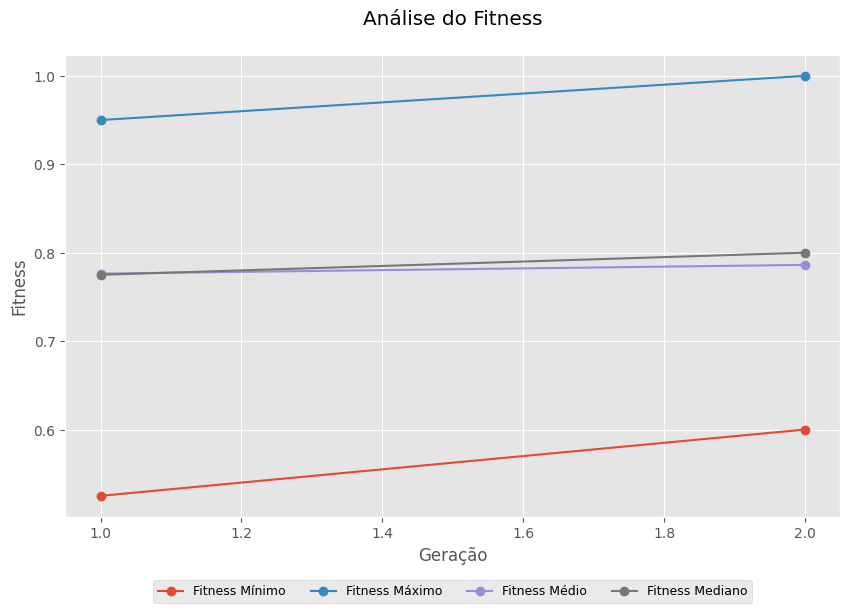

In [ ]:
plot_final_exec()

### Análise pelas Execuções

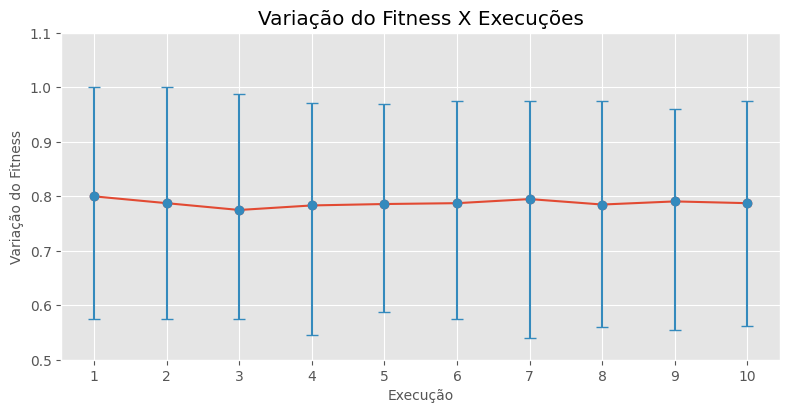

In [ ]:
plot_graphic_2(list(range(10)), min_exec, med_exec, max_exec, "grafico")

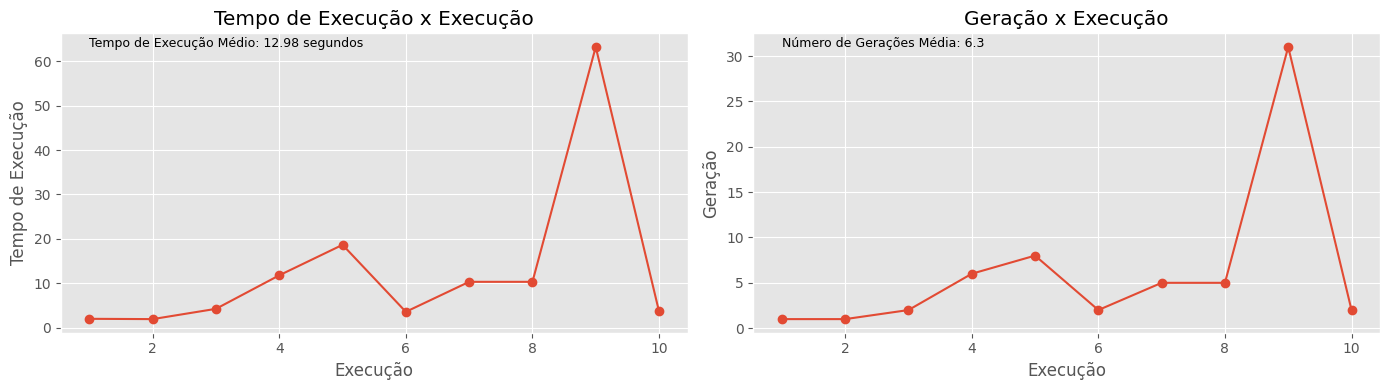

In [ ]:
plot_time_gen_exec()

### Tabelas de Aulas Geradas

#### Melhor Caso

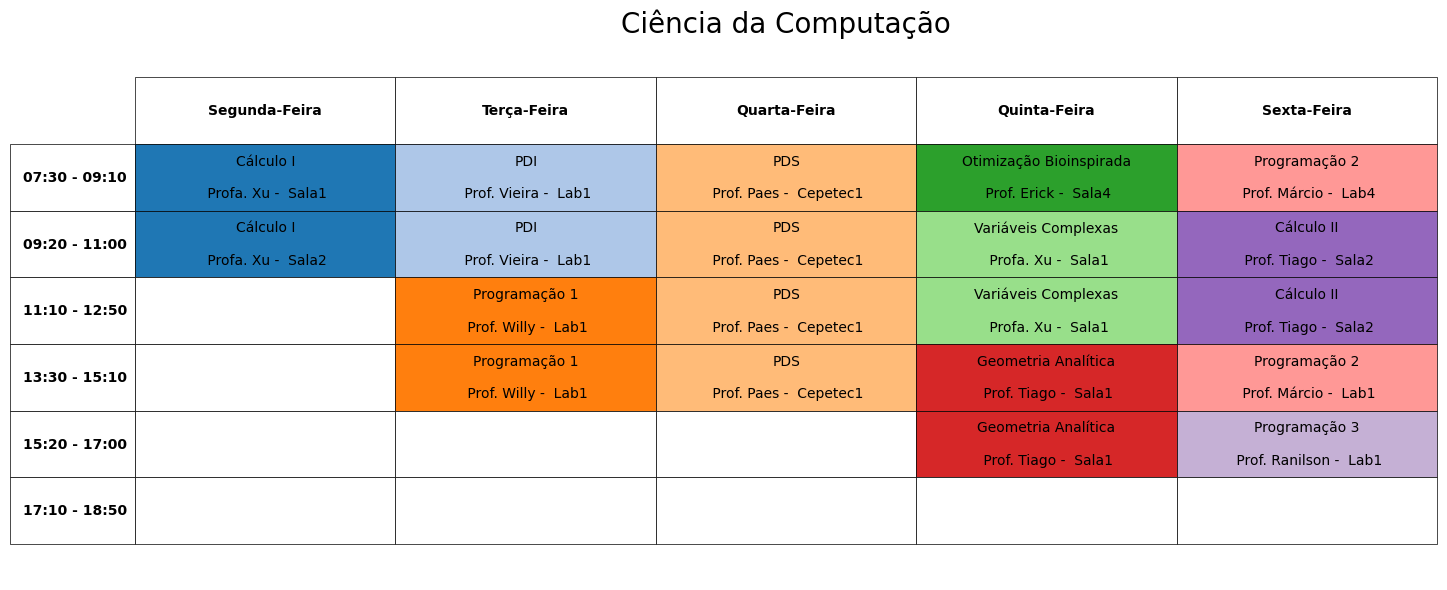

In [ ]:
start = time.time()

time_table = get_time_table(best_individual, classes[0])
plot_time_table(time_table, title=f"{classes[0]}")

period = time.time() - start

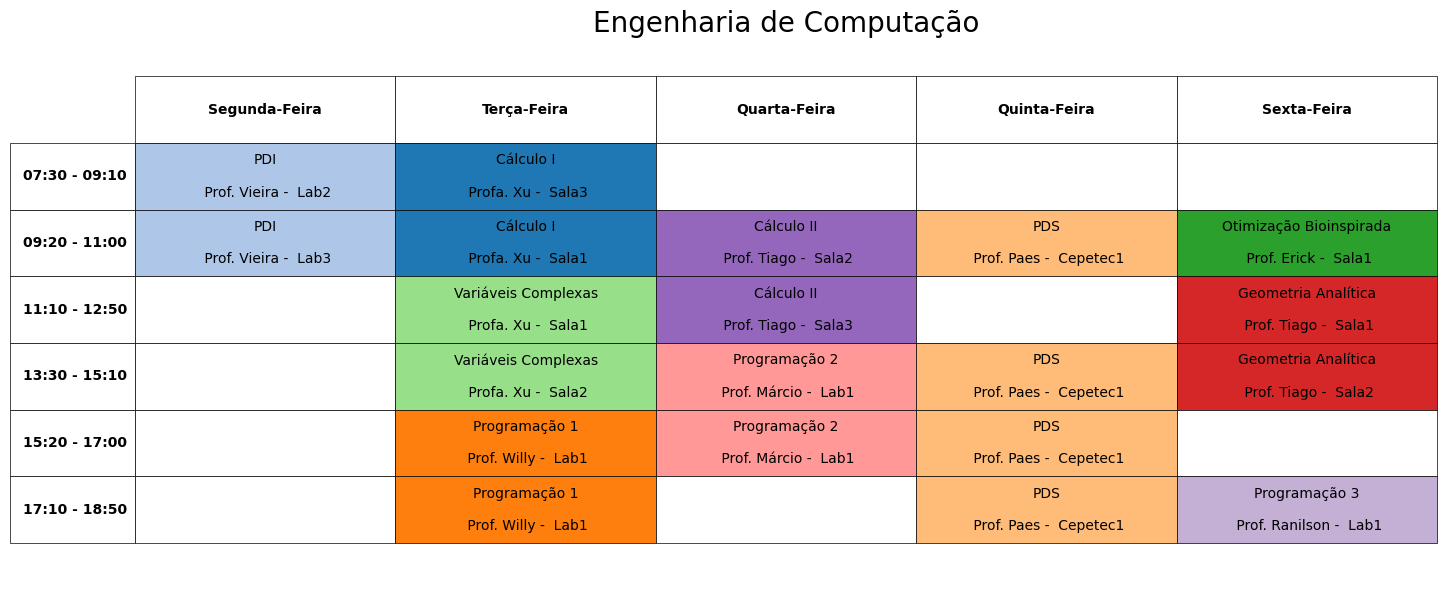

In [ ]:
start = time.time()

time_table = get_time_table(best_individual, classes[1])
plot_time_table(time_table, title=f"{classes[1]}")

period2 = time.time() - start

In [ ]:
print("Tempo para Montar a Tabela 1:", period, "s")
print("Tempo para Montar a Tabela 2:", period2, "s")

Tempo para Montar a Tabela 1: 0.48195838928222656 s
Tempo para Montar a Tabela 2: 0.46411991119384766 s


#### Pior Caso

In [ ]:
fitness_values = list(map(toolbox.evaluate, population))
worst_index = np.argmin(fitness_values)
worst_individual = population[worst_index]

print("Pior indivíduo fitness:", fitness_values[worst_index])
print("Pior indivíduo:", worst_individual)

Pior indivíduo fitness: (0.6,)
Pior indivíduo: [4, 0, 6, 2, 5, 7, 8, 1, 3, 9]


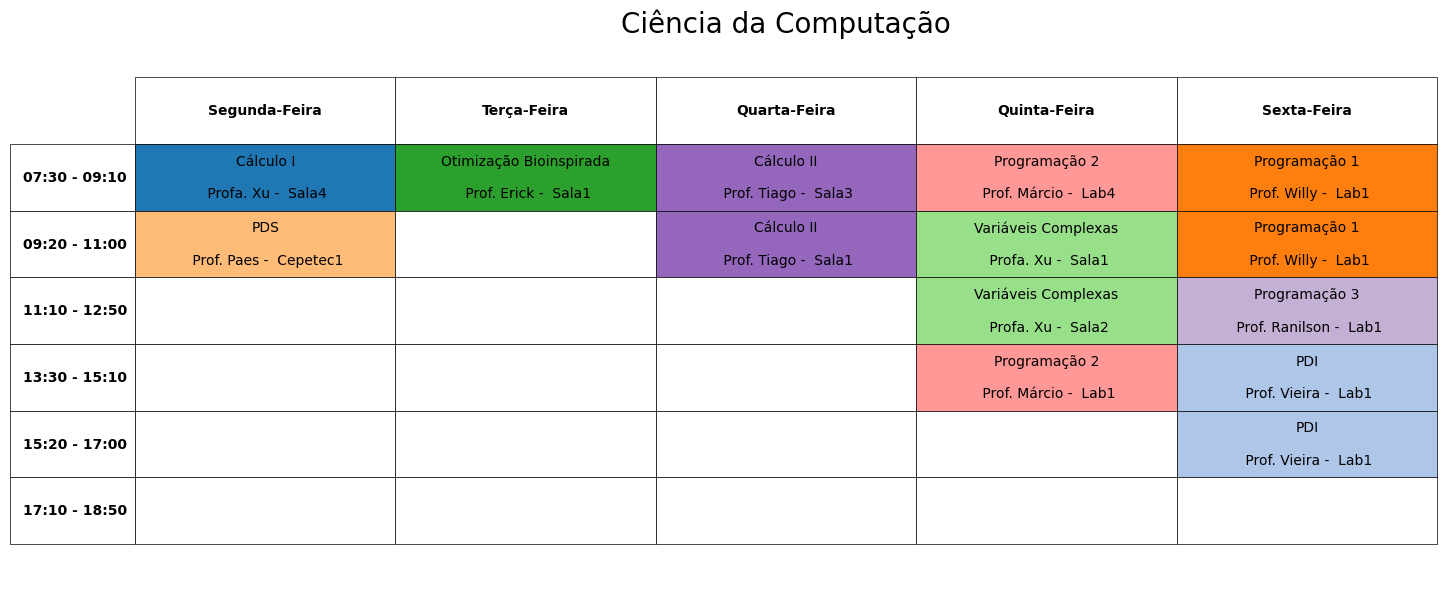

In [ ]:
time_table = get_time_table(worst_individual, classes[0])
plot_time_table(time_table, title=f"{classes[0]}")

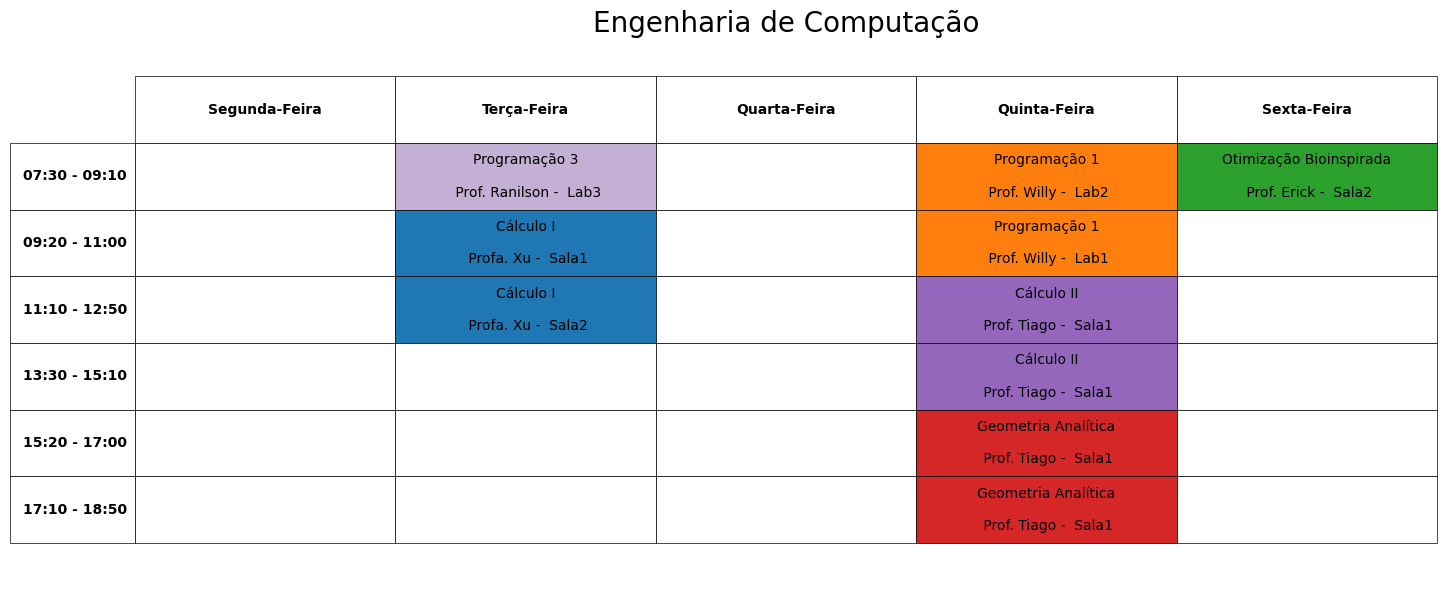

In [ ]:
time_table = get_time_table(worst_individual, classes[1])
plot_time_table(time_table, title=f"{classes[1]}")